![](https://storage.googleapis.com/kaggle-competitions/kaggle/13836/logos/header.png?t=2020-10-01-17-22-54)

Motivation: I wanted to test a new criterion called CutMix, which is shown to greatly improve performance.
The following ideas are implemented in this Notebook:
* Optimizers : Adam, AdamW, AdamP, Ranger
* Schedulers : ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'OneCycleLR' ,'GradualWarmupSchedulerV2']
* Models    : ['deit_base_patch16_384','vit_large_patch16_384','tf_efficientnet_b4_ns','resnext50_32x4d'] it also works for different effnets and resnexts
* Loss Fns   : ['CutMix' + 'TaylorSmoothed']
* Augmentations: LightAug+Cutout(Train),LightAug (only rotations), HeavyAug, AutoAugment(imagenet)

Any feedback is appreciated!
Be sure to also checkout:
* Inference: https://www.kaggle.com/capiru/cassavanet-inference-tta-easy-submission


# What is Cutmix?
Cutmix is a form of transformation, which mixes two images on the same one, similar to mixup as shown below, but with only a portion of the original image. Because we are adding information about another label, the label is also adjusted to match proportionally to what is being inserted.

According to: https://github.com/clovaai/CutMix-PyTorch
* Cutmix Outperforms both CutOut and MixUp

> ![](https://raw.githubusercontent.com/clovaai/CutMix-PyTorch/master/img1.PNG)

Credits:
* Loss Functions: https://www.kaggle.com/piantic/train-cassava-starter-using-various-loss-funcs/data
* TaylorSmoothed: https://www.kaggle.com/yerramvarun/cassava-taylorce-loss-label-smoothing-combo
* GradualWarmup: https://www.kaggle.com/mobassir/faster-pytorch-tpu-baseline-for-cld-cv-0-9#Train-and-eval-function
* FineTuning: https://www.kaggle.com/piantic/how-to-finetuning-models-pytorch-xla-tpu/data#Dataset
* CutMix: https://github.com/clovaai/CutMix-PyTorch

Best CV results for each fold so far (seed 42):
TBA


Inference: https://www.kaggle.com/capiru/cassavanet-inference-tta-easy-submission

Current goal is improving other folds. Any suggestions greatly appreciated :)
Inference is coming soon

v1 - Initial Release / Debug Run

v2 - First Run - TPU

v3 - Finetuning Model - GPU

v4 - Upon further inspection, CutMix was not behaving as intended. Bug should be fixed, as proof the augmentation visualizations are also fixed now as well. Debug Run.

# Run Config

In [1]:
# Configurations
# ====================================================
import os
class CFG:
    DEBUG = False
    
    #Model Params
    device = 'GPU' #['CPU','GPU','TPU']
    N_FOLDS = 5
    MODEL_NAME = 'tf_efficientnet_b4_ns' # Recommended : ['deit_base_patch16_384','vit_large_patch16_384','tf_efficientnet_b4_ns','resnext50_32x4d']
    pretrained = True
    N_CLASSES = 5
    #TRAIN_FOLDS = [0,1,2,3,4]
    TRAIN_FOLDS = [3] #Folds to be Trained
    
    scheduler_name = 'CosineAnnealingWarmRestarts'
    # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'OneCycleLR', 'GradualWarmupSchedulerV2','LambdaLR']
    scheduler_update = 'batch' #['batch','epoch']
    criterion_name = 'TaylorSmoothedLoss'
    # ['CrossEntropyLoss', 'LabelSmoothing', 'FocalLoss','FocalCosineLoss', 'SymmetricCrossEntropyLoss', 'BiTemperedLoss', 'TaylorCrossEntropyLoss', 'TaylorSmoothedLoss']
    optimizer_name = 'AdamW' #['Adam','AdamW','AdamP','Ranger'] -> AdamP doesn't work on TPUs
    LR_RAMPUP_EPOCHS = 1
    LR_SUSTAIN_EPOCHS = 0
    
    FREEZE = False #If you fine tune after START_FREEZE epochs
    START_FREEZE = 0
    
    #Image Size
    HEIGHT = 512 #If VIT or deit is chosen as model: need 384 x 384
    WIDTH = 512
    CHANNELS = 3
    TRAIN_AUG_TYPE = 'lightaug' #['train','lightaug','heavyaug','autoaugment']
    VALID_AUG_TYPE = 'valid' #['valid']
    USE_CUTMIX = True
    CM_START = 0
    CM_alpha = 1
    
    #Training Params
    BATCH_SIZE = 16#48 # PER REPLICA FOR TPUS
    #RECOMMENDED : effnet = 16 ; resnext = 8 ; vit = 4 ; deit = 4
    EPOCHS = 10# more is definitely plausible and recommended around 10
    LR = 2e-4
    LR_START =1e-5
    LR_MIN = 5e-6
    weight_decay = 0
    eps = 1e-8
    PATIENCE = 3
    
    #BiTemperedLoss
    T1 = 0.2
    T2 = 1.1
    LABEL_SMOOTH = 0.2
    
    #CosineAnnealingWarmRestarts
    T_0 = EPOCHS
    
    #CosineAnnealingLR
    T_max = EPOCHS
    
    NUM_WORKERS = 4
    
    model_print = False #If the model architecture is printed
    tqdm = True #If training bar is shown
    
    IMG_MEAN = [0.485, 0.456, 0.406] #Mean for normalization Transform cassava = [0.4303, 0.4967, 0.3134] imgnet = [0.485, 0.456, 0.406]
    IMG_STD = [0.229, 0.224, 0.225] #STD for normalization Transform cassava = [0.2142, 0.2191, 0.1954] imgnet = [0.229, 0.224, 0.225]
    
    USE_2019 = True #Use 2019 images?
    
    #n_procs = number of replicas -> TPU
    n_procs = 1 #You can set it to 1 and run a TPU as a GPU if you want
    BGR = False #Alternate method for loading images -> set to true is a bit slower 
    SEED = 42
    CUTMIX = True

In [2]:
# ====================================================
# Required Installations
# ====================================================
#!pip install --quiet timm==0.3.2

if CFG.device == 'TPU':
    import os
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev
    os.system('export XLA_USE_BF16=1')
    os.system('export XLA_TENSOR_ALLOCATOR_MAXSIZE=100000000')
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.distributed.xla_multiprocessing as xmp
    import ignite.distributed as idist
    #CFG.LR = CFG.LR * CFG.n_procs
    #CFG.BATCH_SIZE = CFG.BATCH_SIZE * CFG.n_procs
    
if CFG.optimizer_name == 'Ranger':
    !pip install --quiet './input/pytorch-ranger'
elif CFG.optimizer_name == 'AdamP':
    !pip install adamp
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    !pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    

# Library

In [3]:
# ====================================================
# Library
# ====================================================
import random
import math
import time

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import cv2
from sklearn.model_selection import GroupKFold, StratifiedKFold

import torch
import torch.nn as nn
import torchvision
from torchvision import models as tvmodels
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from tqdm import tqdm
import timm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold,StratifiedKFold

import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2



from PIL import Image, ImageOps, ImageEnhance, ImageChops


if CFG.optimizer_name == 'Ranger':
    from pytorch_ranger import Ranger
elif CFG.optimizer_name == 'AdamP':
    from adamp import AdamP
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    from warmup_scheduler import GradualWarmupScheduler


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Loss Functions

In [4]:
class LabelSmoothingLoss(nn.Module): 
    def __init__(self, classes=5, smoothing=0.0, dim=-1): 
        super(LabelSmoothingLoss, self).__init__() 
        self.confidence = 1.0 - smoothing 
        self.smoothing = smoothing 
        self.cls = classes 
        self.dim = dim 
    def forward(self, pred, target): 
        if CFG.criterion_name == 'LabelSmoothingLoss':
            pred = pred.log_softmax(dim=self.dim) 
        with torch.no_grad():
            true_dist = torch.zeros_like(pred) 
            true_dist.fill_(self.smoothing / (self.cls - 1)) 
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence) 
        return torch.mean(torch.sum(-true_dist * pred, dim=self.dim))
    
class TaylorSoftmax(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, dim=1, n=2):
        super(TaylorSoftmax, self).__init__()
        assert n % 2 == 0
        self.dim = dim
        self.n = n

    def forward(self, x):
        '''
        usage similar to nn.Softmax:
            >>> mod = TaylorSoftmax(dim=1, n=4)
            >>> inten = torch.randn(1, 32, 64, 64)
            >>> out = mod(inten)
        '''
        fn = torch.ones_like(x)
        denor = 1.
        for i in range(1, self.n+1):
            denor *= i
            fn = fn + x.pow(i) / denor
        out = fn / fn.sum(dim=self.dim, keepdims=True)
        return out
    
class TaylorCrossEntropyLoss(nn.Module):
    '''
    This is the autograd version
    '''
    def __init__(self, n=2, ignore_index=-1, reduction='mean'):
        super(TaylorCrossEntropyLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index

    def forward(self, logits, labels):
        '''
        usage similar to nn.CrossEntropyLoss:
            >>> crit = TaylorCrossEntropyLoss(n=4)
            >>> inten = torch.randn(1, 10, 64, 64)
            >>> label = torch.randint(0, 10, (1, 64, 64))
            >>> out = crit(inten, label)
        '''
        log_probs = self.taylor_softmax(logits).log()
        loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
                ignore_index=self.ignore_index)
        return loss
    
class TaylorSmoothedLoss(nn.Module):

    def __init__(self, n=2, ignore_index=-1, reduction='mean', smoothing=0.2):
        super(TaylorSmoothedLoss, self).__init__()
        assert n % 2 == 0
        self.taylor_softmax = TaylorSoftmax(dim=1, n=n)
        self.reduction = reduction
        self.ignore_index = ignore_index
        self.lab_smooth = LabelSmoothingLoss(CFG.N_CLASSES, smoothing=CFG.LABEL_SMOOTH)

    def forward(self, logits, labels):

        log_probs = self.taylor_softmax(logits).log()
        #loss = F.nll_loss(log_probs, labels, reduction=self.reduction,
        #        ignore_index=self.ignore_index)
        loss = self.lab_smooth(log_probs, labels)
        return loss
    
class CutMixCriterion(nn.Module):
    def __init__(self, criterion):
        super(CutMixCriterion, self).__init__()
        self.criterion = criterion

    def forward(self, preds, targets):
        targets1 = targets[:,0]
        targets2 = targets[:,1]
        lam = targets[0,2]
        return lam * self.criterion.forward(
            preds, targets1) + (1 - lam) * self.criterion.forward(preds, targets2)

# Augmentations

In [5]:
# ====================================================
# Augmentations
# ====================================================
Aug_Norm = A.Normalize(mean=CFG.IMG_MEAN, std=CFG.IMG_STD, max_pixel_value=255.0, p=1.0)
Drop_Rand = A.CoarseDropout(max_holes=12, max_height=int(0.11*CFG.HEIGHT), max_width=int(0.11*CFG.WIDTH),
                            min_holes=1, min_height=int(0.03*CFG.HEIGHT), min_width=int(0.03*CFG.WIDTH),
                            always_apply=False, p=0.5)
Rand_Crop = A.RandomCrop(height= CFG.HEIGHT, width = CFG.WIDTH,always_apply=True, p=1.0)
Resize_Crop = A.RandomResizedCrop(CFG.HEIGHT, CFG.WIDTH,p=1.0)
train_transforms = Compose([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
            A.RandomBrightnessContrast(
                    brightness_limit=(-0.1,0.1), 
                    contrast_limit=(-0.1, 0.1), 
                    p=0.5
                ),
            Resize_Crop,
            Drop_Rand,           
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

light_transforms = Compose([
            A.Transpose(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=0.5),
            A.HueSaturationValue(
                        hue_shift_limit=0.2, 
                        sat_shift_limit=0.2, 
                        val_shift_limit=0.2, 
                        p=0.5),
            A.RandomBrightnessContrast(
                            brightness_limit=(-0.1,0.1), 
                            contrast_limit=(-0.1, 0.1), 
                            p=0.5),
            Resize_Crop,
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

heavy_transforms = Compose([
    A.HorizontalFlip(p=0.5),
    
    A.Resize(CFG.HEIGHT, CFG.WIDTH),
    
    A.Transpose(p=0.5),
    A.VerticalFlip(p=0.5),
    #A.augmentations.transforms.ColorJitter(brightness=0.10, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.augmentations.transforms.RGBShift (r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, always_apply=False, p=0.5),
    A.augmentations.transforms.ChannelDropout (channel_drop_range=(1, 1), fill_value=0, always_apply=False, p=0.5),
    
    A.augmentations.transforms.GridDistortion (num_steps=5, distort_limit=0.3, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.CoarseDropout(p=0.5),
    A.Cutout(p=0.5),
    Aug_Norm,
    ToTensorV2(p=1.0),])

valid_transforms = Compose([
            A.CenterCrop(CFG.HEIGHT, CFG.WIDTH),
            Aug_Norm,   
            ToTensorV2(p=1.0),
        ], p=1.)

test_aug = Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.ShiftScaleRotate(p = 1.0),
            #A.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.2, hue=0.00, always_apply=False, p=1.0),
            Rand_Crop,
            Aug_Norm,
            ToTensorV2(p=1.0)
        ], p=1.)

image_net_post = Compose([
            Resize_Crop,
            Drop_Rand,
            Aug_Norm,    
            ToTensorV2(p=1.0)
        ], p=1.)

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

# Utils

In [6]:
# ====================================================
# Utils
# ====================================================
def retrieve_df(df,name,idx):
    series = df[name].iloc[idx]
    series.reset_index(drop=True,inplace=True)
    return series

def accuracy_metric(input, targs):
    return accuracy_score(targs.cpu(), input.cpu())

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
    class GradualWarmupSchedulerV2(GradualWarmupScheduler):
        def __init__(self, optimizer = None, multiplier = CFG.LR/CFG.LR_START, total_epoch = CFG.LR_RAMPUP_EPOCHS, after_scheduler=None):
            super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
            self.after_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CFG.T_0 - CFG.LR_RAMPUP_EPOCHS, T_mult=1, eta_min=CFG.LR_MIN, last_epoch=-1)
        def get_lr(self):
            if self.last_epoch > self.total_epoch:
                if self.after_scheduler:
                    if not self.finished:
                        self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                        self.finished = True
                    return self.after_scheduler.get_lr()
                return [base_lr * self.multiplier for base_lr in self.base_lrs]
            if self.multiplier == 1.0:
                return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
            else:
                return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

#Choose Criterions for the Training Loop
def GetCriterion(criterion_name):
    if criterion_name == 'BiTemperedLoss':
        criterion = BiTemperedLogistic()
    elif criterion_name == 'SymmetricCrossEntropyLoss':
        criterion = SymmetricCrossEntropy()
    elif criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    elif criterion_name == 'LabelSmoothingLoss':
        criterion = LabelSmoothingLoss()
    elif criterion_name == 'FocalLoss':
        criterion = FocalLoss()
    elif criterion_name == 'FocalCosineLoss':
        criterion = FocalCosineLoss()
    elif criterion_name == 'TaylorCrossEntropyLoss':
        criterion = TaylorCrossEntropyLoss()
    elif criterion_name == 'TaylorSmoothedLoss':
        criterion = TaylorSmoothedLoss()
    elif criterion_name == 'CutMix':
        criterion = CutMixCriterion(GetCriterion(CFG.criterion_name))
    return criterion
    
    
def GetScheduler(scheduler_name,optimizer,batches):
    #['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'OneCycleLR', 'GradualWarmupSchedulerV2']
    if scheduler_name == 'OneCycleLR':
        return torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr = 1e-2,epochs = CFG.EPOCHS,steps_per_epoch = batches+1,pct_start = 0.1)
    elif scheduler_name == 'CosineAnnealingWarmRestarts':
        return torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = CFG.T_0, T_mult=1, eta_min=CFG.LR_MIN, last_epoch=-1)
    elif scheduler_name == 'CosineAnnealingLR':
        return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = CFG.T_max, eta_min=0, last_epoch=-1)
    elif scheduler_name == 'ReduceLROnPlateau':
        return torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.1, patience=1, threshold=0.0001, cooldown=0, min_lr=CFG.LR_MIN, eps=CFG.eps)
    elif scheduler_name == 'GradualWarmupSchedulerV2':
        return GradualWarmupSchedulerV2(optimizer=optimizer)
    
def GetOptimizer(optimizer_name,parameters):
    #['Adam','Ranger']
    if optimizer_name == 'Adam':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return torch.optim.Adam(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay, amsgrad=False)
        else:
            return torch.optim.Adam(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay, amsgrad=False)
    elif optimizer_name == 'AdamW':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return torch.optim.AdamW(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay, amsgrad=False)
        else:
            return torch.optim.Adam(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay, amsgrad=False)
    elif optimizer_name == 'AdamP':
        if CFG.scheduler_name == 'GradualWarmupSchedulerV2':
            return AdamP(parameters, lr=CFG.LR_START, weight_decay=CFG.weight_decay)
        else:
            return AdamP(parameters, lr=CFG.LR, weight_decay=CFG.weight_decay)
    elif optimizer_name == 'Ranger':
        return Ranger(parameters,lr = CFG.LR,alpha = 0.5, k = 6,N_sma_threshhold = 5,betas = (0.95,0.999),eps=CFG.eps,weight_decay=CFG.weight_decay)

def print_scheduler(scheduler = None,scheduler_update = CFG.scheduler_update,optimizer = None, batches = -1, epochs = -1, model = None):
    lrs = []
    if scheduler_update == 'epoch':
        for epoch in range(epochs):
            scheduler.step(epoch)
            lrs.append(optimizer.param_groups[0]["lr"])
        plt.figure(figsize=(15,4))
        plt.plot(lrs)
    elif scheduler_update == 'batch':
        for epoch in range(epochs):
            for batch in range(batches):
                scheduler.step()
                lrs.append(optimizer.param_groups[0]["lr"])
        plt.figure(figsize=(15,4))
        plt.plot(lrs)

def cutmix(batch):
    batch_size = len(batch)
    data = np.zeros((batch_size,CFG.CHANNELS,CFG.HEIGHT,CFG.WIDTH))
    targets = np.zeros((batch_size))
    for i in range(batch_size):
        data[i,:,:,:] = batch[i][0]
        targets[i] = batch[i][1]

    indices = torch.randperm(batch_size)
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]

    lam = np.random.beta(CFG.CM_alpha, CFG.CM_alpha)

    image_h, image_w = data.shape[2:]
    cx = np.random.uniform(0, image_w)
    cy = np.random.uniform(0, image_h)
    w = image_w * np.sqrt(1 - lam)
    h = image_h * np.sqrt(1 - lam)
    x0 = int(np.round(max(cx - w / 2, 0)))
    x1 = int(np.round(min(cx + w / 2, image_w)))
    y0 = int(np.round(max(cy - h / 2, 0)))
    y1 = int(np.round(min(cy + h / 2, image_h)))

    data[:, :, y0:y1, x0:x1] = shuffled_data[:, :, y0:y1, x0:x1]
    return_targets = torch.zeros((batch_size,3),dtype=torch.int64)
    return_targets[:,0] = torch.from_numpy(targets)
    return_targets[:,1] = torch.from_numpy(shuffled_targets)
    return_targets[0,2] = lam

    return torch.from_numpy(data), return_targets
        
class CutMixCollator:
    def __call__(self, batch):
        #batch = torch.utils.data.dataloader.default_collate(batch)
        batch = cutmix(batch)
        return batch

    
SEED = CFG.SEED
seed_everything(SEED)  
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Datasets

In [7]:
# ====================================================
# Datasets
# ====================================================
class GetData(Dataset):
    def __init__(self, Dir, FNames, labels,Type):
        self.dir = Dir
        self.fnames = FNames
        self.lbs = labels
        self.type = Type
        self.auto_augment = timm.data.auto_augment.auto_augment_transform('originalr',None)
        
    def __len__(self):
        return len(self.fnames)
    
    def get_x(self,index):
        if CFG.BGR:
            x = cv2.imread(os.path.join(self.dir, self.fnames[index]))
            x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
        else:
            x = imread(os.path.join(self.dir, self.fnames[index]))
        return x

    def __getitem__(self, index):
        if "train" in self.type:
            x = self.get_x(index)
            aug_data = train_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "lightaug" in self.type:
            x = self.get_x(index)
            aug_data = light_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "heavyaug" in self.type:
            x = self.get_x(index)
            aug_data = heavy_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "autoaugment" in self.type:
            x = Image.open(os.path.join(self.dir, self.fnames[index]))
            aug_image = self.auto_augment(x)
            aug_data = image_net_post(image = np.asarray(aug_image,dtype = np.float32))
            return aug_data['image'], self.lbs[index]
        elif "valid" in self.type:
            x = self.get_x(index)
            aug_data = valid_transforms(image = x)
            return aug_data['image'], self.lbs[index]
        elif "tr-tst" in self.type:
            x = self.get_x(index)
            return x, self.lbs[index]
        elif "test" in self.type:
            x = self.get_x(index)
            return x, self.fnames[index]

# CV SPLIT

In [8]:
# ====================================================
# CV Split
# ====================================================
DATA_PATH = './input/cassava-leaf-disease-classification/'
TRAIN_DIR = DATA_PATH + 'train_images/'

DATA_PATH_2019 = './input/cassava-leaf-disease-merged/'
TRAIN_DIR_2019 = DATA_PATH_2019 + 'train/'
TEST_DIR = DATA_PATH + 'test_images/'

#This guarantees that no images from 2019 contaminate the validation split
if CFG.USE_2019:
    train_df_merged = pd.read_csv(DATA_PATH_2019 + 'merged.csv')
    train_df = train_df_merged.loc[train_df_merged.source == 2020]
    if CFG.DEBUG:
        train_df = train_df.sample(500).reset_index(drop=True)
    train_df_2019 = train_df_merged.loc[train_df_merged.source == 2019]
    skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
    skf.get_n_splits(np.arange(train_df.shape[0]), train_df['label'])
    folds = [(idxT,idxV) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df.shape[0]), train_df['label']))]
    if not CFG.DEBUG:
        folds_2019 = [np.concatenate((idxT,idxV)) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df_2019.shape[0]), train_df_2019['label']))]
        for i in range(CFG.N_FOLDS):
            (idxT,idxV) = folds[i]
            folds[i] = (np.concatenate((idxT,train_df_2019.iloc[folds_2019[i]].index)),idxV)
            (idxT,idxV) = folds[i]
            print(np.bincount(train_df_merged['label'].iloc[idxT]),np.bincount(train_df['label'].iloc[idxV]))
    DATA_FOLD = TRAIN_DIR_2019
    del train_df_2019
else:
    train_df = pd.read_csv(DATA_PATH + 'train.csv')
    if CFG.DEBUG:
        train_df = train_df.sample(500).reset_index(drop=True)
    skf = StratifiedKFold(n_splits=CFG.N_FOLDS, shuffle=True, random_state=CFG.SEED)
    skf.get_n_splits(np.arange(train_df.shape[0]), train_df['label'])
    folds = [(idxT,idxV) for i,(idxT,idxV) in enumerate(skf.split(np.arange(train_df.shape[0]), train_df['label']))]
    for i in range(CFG.N_FOLDS):
        (idxT,idxV) = folds[i]
        print(np.bincount(train_df['label'].iloc[idxT]),np.bincount(train_df['label'].iloc[idxV]))
    
    train_df_merged = train_df
    DATA_FOLD = TRAIN_DIR

[ 1274  3038  2540 12831  2374] [ 218  438  477 2631  516]
[ 1274  3038  2540 12831  2374] [ 218  438  477 2631  516]
[ 1275  3038  2540 12830  2375] [ 217  438  477 2632  515]
[ 1275  3038  2540 12830  2375] [ 217  438  477 2632  515]
[ 1275  3039  2539 12830  2375] [ 217  437  478 2632  515]


# Augmentation Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

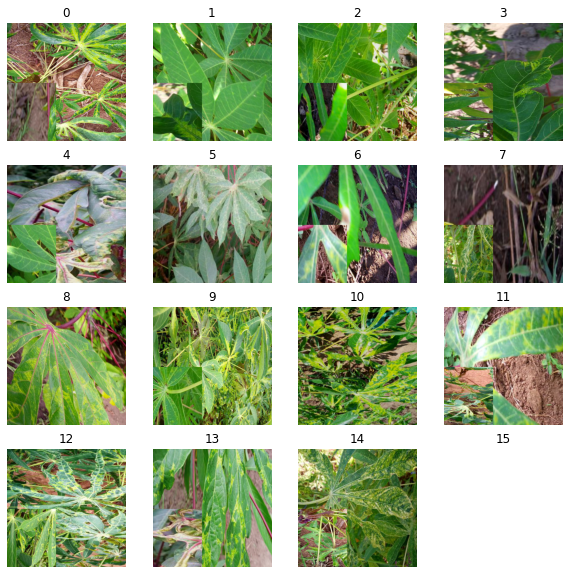

In [9]:
idx = [i for i in range(16)]
x_train = retrieve_df(train_df_merged,'image_id',idx)
y_train = retrieve_df(train_df_merged,'label',idx)
CFG.collator = CutMixCollator()
train_set = GetData(DATA_FOLD, x_train, y_train, Type = CFG.TRAIN_AUG_TYPE)
train_loader = DataLoader(train_set,batch_size = 16,collate_fn = CFG.collator, shuffle=False,drop_last=True, num_workers=CFG.NUM_WORKERS,pin_memory = True)
plt.figure(figsize=(10, 10))
inv_normalize = UnNormalize(mean = CFG.IMG_MEAN,std = CFG.IMG_STD)
for i,(image,label) in enumerate(train_loader):
    #image,a = cutmix((image,label),CFG.CM_alpha)
    for j in range(16):
        aug_image = inv_normalize(image[j,:,:,:]).reshape((CFG.CHANNELS,CFG.HEIGHT,CFG.WIDTH))
        aug_image = np.transpose(aug_image.numpy(),[1,2,0])
        plt.imshow(aug_image)
        ax = plt.subplot(4, 4, j+1)
        label = train_df['label'].iloc[j]
        plt.title(j)
        plt.axis("off")
    if i == 0:
        break
del aug_image,label,image,ax,train_set,train_loader

# Model

In [10]:
# ====================================================
# Model
# ====================================================
class CassavaNet(nn.Module):
    def __init__(self, model_name=CFG.MODEL_NAME, pretrained=CFG.pretrained):
        super().__init__()
        self.model_name = model_name
        if model_name == 'deit_base_patch16_224' or model_name == 'deit_base_patch16_384':
            self.model = torch.hub.load('facebookresearch/deit:main', model_name, pretrained=pretrained)
        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)
        if 'efficientnet' in model_name:
            self.n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(self.n_features, CFG.N_CLASSES)
        elif model_name == 'vit_large_patch16_384' or model_name == 'deit_base_patch16_224' or model_name == 'deit_base_patch16_384':
            self.n_features = self.model.head.in_features
            self.model.head = nn.Linear(self.n_features, CFG.N_CLASSES)
        elif 'resnext' in model_name:
            self.n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(self.n_features, CFG.N_CLASSES)
        
    def forward(self, x):
        return self.model(x)
    
    def freeze(self):
        # To freeze the residual layers
        for param in self.model.parameters():
            param.requires_grad = False
            
        if 'efficientnet' in self.model_name:
            for param in self.model.classifier.parameters():
                param.requires_grad = True
        elif self.model_name == 'vit_large_patch16_384' or 'deit_base_patch16_224':
            for param in self.model.head.parameters():
                param.requires_grad = True
        elif 'resnext' in self.model_name:
            for param in self.model.fc.parameters():
                param.requires_grad = True
            
    def unfreeze(self):
        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

In [11]:
model = CassavaNet()
if CFG.model_print:
    print(model)

# Train Loop

In [12]:
def train_one_epoch(model,optimizer,scheduler,scaler,train_loader,criterion,batches,epoch,DEVICE):   
    tr_loss = 0.0
    scores = 0.0
    trn_epoch_result = dict()
    model.train()
    if CFG.tqdm:
        progress = tqdm(enumerate(train_loader), desc="Loss: ", total=len(train_loader))
    else:
        progress = enumerate(train_loader)
    for i, (images,labels) in progress:
        images = images.to(DEVICE, dtype=torch.float)
        labels = labels.to(DEVICE)
        
        optimizer.zero_grad()
        
        if CFG.device == 'TPU':
            logits = model(images)
            loss = criterion(logits, labels)
            loss.backward()
            xm.optimizer_step(optimizer)
        else:
            with autocast():
                logits = model(images)
                loss = criterion(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        
        preds = F.softmax(logits).argmax(axis = 1)
        if not CFG.CUTMIX:
            scores += (preds==labels).sum().cpu().numpy()
        else:
            if labels[0,2] >= 0.5:
                scores += (preds==labels[:,0]).sum().cpu().numpy()
            else:
                scores += (preds==labels[:,1]).sum().cpu().numpy()

        
        if CFG.scheduler_update == 'batch':
            if not CFG.scheduler_name == 'OneCycleLR':
                scheduler.step(epoch + i/len(train_loader))
            else:
                scheduler.step()

        tr_loss += loss.detach().item()
        
        if CFG.tqdm:
            trn_epoch_result['Epoch'] = epoch
            trn_epoch_result['train_loss'] = round(tr_loss/(i+1), 4)
            trn_epoch_result['train_acc'] = round(scores/(i+1)/CFG.BATCH_SIZE, 4)
            trn_epoch_result['LR'] = round(optimizer.param_groups[0]["lr"],7)

            progress.set_description(str(trn_epoch_result))
        else:
            print(tr_loss/(i+1))
    if CFG.scheduler_update == 'epoch':
            scheduler.step(epoch+1)
        
def val_one_epoch(model,DEVICE,loader,val_criterion,epoch,get_output = False):
    val_loss = 0.0
    scores = 0.0
    model.eval()
    val_progress = tqdm(enumerate(loader), desc="Loss: ", total=len(loader))
    with torch.no_grad():
        for i, (images,labels) in val_progress:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)

            logits = model(images)
            val_loss_value = val_criterion(logits,labels)
            val_loss += val_loss_value.detach().item()

            preds = F.softmax(logits).argmax(axis = 1)
            scores += (preds==labels).sum().cpu().numpy()

            val_epoch_result = dict()
            val_epoch_result['Epoch'] = epoch
            val_epoch_result['val_loss'] = round(val_loss/(i+1), 4)

            val_epoch_result['val_acc'] = round(scores/(i+1)/CFG.BATCH_SIZE, 4)
            val_progress.set_description(str(val_epoch_result))
    if get_output:
        return val_loss/len(loader),scores/len(loader)/CFG.BATCH_SIZE

def get_loaders(dev=None,train_set=None,val_set=None):
    if dev == 'TPU':
        train_sampler = torch.utils.data.distributed.DistributedSampler(
            train_set,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=True)
        train_loader = DataLoader(train_set, batch_size=CFG.BATCH_SIZE, sampler=train_sampler,drop_last=True,collate_fn=CFG.collator, num_workers=CFG.NUM_WORKERS)

        val_sampler = torch.utils.data.distributed.DistributedSampler(
            val_set,
            num_replicas=xm.xrt_world_size(),
            rank=xm.get_ordinal(),
            shuffle=False)
        val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE, sampler=val_sampler,drop_last=True, num_workers=CFG.NUM_WORKERS)
        scaler = None
    else:
        train_loader = DataLoader(train_set, batch_size=CFG.BATCH_SIZE, shuffle=True,drop_last=True,collate_fn=CFG.collator, num_workers=CFG.NUM_WORKERS,pin_memory = True)
        val_loader = DataLoader(val_set, batch_size=CFG.BATCH_SIZE, shuffle=False,drop_last=True, num_workers=CFG.NUM_WORKERS,pin_memory = True)
        scaler = GradScaler()
    return train_loader,val_loader,scaler

def model_train():
    if CFG.device == 'TPU':
        DEVICE = xm.xla_device()
    else:
        DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
    for fold,(idxT, idxV) in enumerate(folds):
        if fold not in CFG.TRAIN_FOLDS:
            continue
        #if xm.is_master_ordinal():
        #    xm.master_print(fold)
        #______INSTANTIATE TRAINING DATASETS_____
        x_train = retrieve_df(train_df_merged,'image_id',idxT)
        y_train = retrieve_df(train_df_merged,'label',idxT)
        x_val = retrieve_df(train_df_merged,'image_id',idxV)
        y_val = retrieve_df(train_df_merged,'label',idxV)
        train_set = GetData(DATA_FOLD, x_train, y_train, Type = CFG.TRAIN_AUG_TYPE)
        val_set = GetData(DATA_FOLD, x_val, y_val, Type = CFG.VALID_AUG_TYPE)
        CFG.collator = torch.utils.data.dataloader.default_collate
        train_loader,val_loader,scaler = get_loaders(dev=CFG.device,train_set=train_set,val_set=val_set)
            
        batches = len(train_loader)
        val_batches = len(val_loader)

        #INSTANTIATE FOLD MODEL
        if CFG.model is None:
            if CFG.device == 'TPU':
                if xm.is_master_ordinal(local=True):
                    CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)
                xm.rendezvous('ModelDone')
            else:
                CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)
        model = CFG.model.to(DEVICE, dtype=torch.float)

        criterion = GetCriterion(CFG.criterion_name)
        val_criterion = GetCriterion(CFG.criterion_name)

        optimizer = GetOptimizer(CFG.optimizer_name, model.parameters())
        scheduler = GetScheduler(CFG.scheduler_name, optimizer,batches)
        
        saved_model = None
        best_val_acc = 0.0
        best_val_loss = 1e3
        fold_patience = 0.0
        for epoch in range(CFG.EPOCHS):
            if epoch >= CFG.START_FREEZE and CFG.FREEZE:
                print('Model Frozen -> Train Classifier Only')
                if saved_model is not None:
                    info = torch.load(saved_model,map_location = torch.device(DEVICE))
                    model.load_state_dict(info)
                model.freeze()
                
                CFG.FREEZE = False
            if epoch>= CFG.CM_START and CFG.USE_CUTMIX:
                print('Using CutMix')
                CFG.CUTMIX = True
                CFG.collator = CutMixCollator()
                criterion = GetCriterion('CutMix')
                val_criterion = GetCriterion(CFG.criterion_name)
                train_loader,val_loader,scaler = get_loaders(dev=CFG.device,train_set=train_set,val_set=val_set)
                
                CFG.USE_CUTMIX = False
            #______TRAINING______
            if CFG.device == 'TPU':
                para_train_loader = pl.ParallelLoader(train_loader, [DEVICE])
                train_one_epoch(model,optimizer,scheduler,scaler,para_train_loader.per_device_loader(DEVICE),criterion,batches,epoch,DEVICE)
                del para_train_loader
                gc.collect()
            else:
                train_one_epoch(model,optimizer,scheduler,scaler,train_loader,criterion,batches,epoch,DEVICE)
            
            #______VALIDATION_______
            if CFG.device == 'TPU':
                para_val_loader = pl.ParallelLoader(val_loader, [DEVICE])
                val_loss, val_acc = val_one_epoch(model,DEVICE,para_val_loader.per_device_loader(DEVICE),val_criterion,epoch,get_output = True)
                del para_val_loader
                gc.collect()
                val_loss = np.sum(idist.all_gather(torch.tensor(val_loss)).to('cpu').numpy())/CFG.n_procs
                val_acc = np.sum(idist.all_gather(torch.tensor(val_acc)).to('cpu').numpy())/CFG.n_procs
                xm.master_print(f'Fold Ended at {round(val_acc, 4)} val accuracy')
            else:
                val_loss, val_acc = val_one_epoch(model,DEVICE,val_loader,val_criterion,epoch,get_output = True)
            
            if val_acc > best_val_acc:
                fold_patience = 0
                best_val_loss = val_loss/val_batches
                best_val_acc = val_acc
                if CFG.device == 'TPU':
                    xm.save(CFG.model.state_dict(),
                                f'{CFG.MODEL_NAME}_f{fold}_TPU_b{round(best_val_acc, 4)}.pth')
                    if saved_model is not None:
                        try:
                            os.remove("./"+saved_model)
                        except:
                            a = 1
                    xm.master_print(f'Model Saved at {round(best_val_acc, 5)} accuracy')
                    saved_model = f'{CFG.MODEL_NAME}_f{fold}_TPU_b{round(best_val_acc, 4)}.pth'
                else:
                    torch.save(model.state_dict(),
                            f'{CFG.MODEL_NAME}_f{fold}_b{round(best_val_acc, 4)}.pth')
                    if saved_model is not None:
                        try:
                            os.remove("./"+saved_model)
                        except:
                            a = 1
                    saved_model = f'{CFG.MODEL_NAME}_f{fold}_b{round(best_val_acc, 4)}.pth'
                
                    print(f'Model Saved at {round(best_val_acc, 5)} accuracy')
            else:
                fold_patience += 1
                if fold_patience >= CFG.PATIENCE:
                    print(f'Early stopping due to model not improving for {CFG.PATIENCE} epochs')
                    CFG.model = None
                    break
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        CFG.model = None
                
def _map_fn(index,flags):
    torch.set_default_tensor_type('torch.FloatTensor')
    a = model_train()

In [13]:
import gc
gc.collect()

32746

In [14]:
CFG.model = CassavaNet(model_name=CFG.MODEL_NAME, pretrained=True)

In [15]:
if CFG.device == 'TPU':
    FLAGS = {}
    xmp.spawn(_map_fn, args=(FLAGS,), nprocs=CFG.n_procs, start_method='fork')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    a = model_train()

Using CutMix


{'Epoch': 0, 'train_loss': 1.2208, 'train_acc': 0.6785, 'LR': 0.0001952}: 100%|██████████| 1378/1378 [07:35<00:00,  3.03it/s]
{'Epoch': 0, 'val_loss': 0.9965, 'val_acc': 0.8481}: 100%|██████████| 267/267 [00:24<00:00, 11.11it/s]


Model Saved at 0.84808 accuracy


{'Epoch': 1, 'train_loss': 1.1131, 'train_acc': 0.7531, 'LR': 0.0001814}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]
{'Epoch': 1, 'val_loss': 0.9671, 'val_acc': 0.8666}: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]


Model Saved at 0.86657 accuracy


{'Epoch': 2, 'train_loss': 1.0841, 'train_acc': 0.7764, 'LR': 0.0001598}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]
{'Epoch': 2, 'val_loss': 0.9953, 'val_acc': 0.8502}: 100%|██████████| 267/267 [00:23<00:00, 11.30it/s]
{'Epoch': 3, 'train_loss': 1.0703, 'train_acc': 0.7918, 'LR': 0.0001327}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]
{'Epoch': 3, 'val_loss': 0.9889, 'val_acc': 0.8523}: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]
{'Epoch': 4, 'train_loss': 1.055, 'train_acc': 0.7992, 'LR': 0.0001025}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s] 
{'Epoch': 4, 'val_loss': 0.947, 'val_acc': 0.8841}: 100%|██████████| 267/267 [00:23<00:00, 11.30it/s] 


Model Saved at 0.88413 accuracy


{'Epoch': 5, 'train_loss': 1.0469, 'train_acc': 0.807, 'LR': 7.24e-05}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s] 
{'Epoch': 5, 'val_loss': 0.9304, 'val_acc': 0.8928}: 100%|██████████| 267/267 [00:23<00:00, 11.29it/s]


Model Saved at 0.89279 accuracy


{'Epoch': 6, 'train_loss': 1.0364, 'train_acc': 0.8133, 'LR': 4.52e-05}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]
{'Epoch': 6, 'val_loss': 0.9362, 'val_acc': 0.8895}: 100%|██████████| 267/267 [00:23<00:00, 11.29it/s]
{'Epoch': 7, 'train_loss': 1.0278, 'train_acc': 0.8199, 'LR': 2.36e-05}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]
{'Epoch': 7, 'val_loss': 0.9272, 'val_acc': 0.8935}: 100%|██████████| 267/267 [00:23<00:00, 11.27it/s]


Model Saved at 0.89349 accuracy


{'Epoch': 8, 'train_loss': 1.0209, 'train_acc': 0.824, 'LR': 9.8e-06}: 100%|██████████| 1378/1378 [07:31<00:00,  3.06it/s]  
{'Epoch': 8, 'val_loss': 0.9255, 'val_acc': 0.8954}: 100%|██████████| 267/267 [00:23<00:00, 11.28it/s]


Model Saved at 0.89537 accuracy


{'Epoch': 9, 'train_loss': 1.0185, 'train_acc': 0.8281, 'LR': 5e-06}: 100%|██████████| 1378/1378 [07:31<00:00,  3.05it/s]  
{'Epoch': 9, 'val_loss': 0.9269, 'val_acc': 0.8937}: 100%|██████████| 267/267 [00:23<00:00, 11.30it/s]
